In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [3]:
#see milling_example.data for more info about input data
dataset_path = keras.utils.get_file("milling.data","D:\\milling_example.data")
dataset_path

'C:\\Users\\Skyon\\.keras\\datasets\\milling.data'

In [4]:
column_names = ['Cutting force, N','Deformation of the workpiece, mm', 'Feed S, mm']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail(10)

,"Cutting force, N","Deformation of the workpiece, mm","Feed S, mm"
170,203.813,0.002,0.15
171,203.813,0.002,0.15
172,203.813,0.002,0.15
173,203.813,0.002,0.15
174,203.813,0.002,0.15
175,203.813,0.002,0.15
176,203.813,0.002,0.15
177,203.813,0.002,0.15
178,203.813,0.002,0.15
179,203.813,0.002,0.15


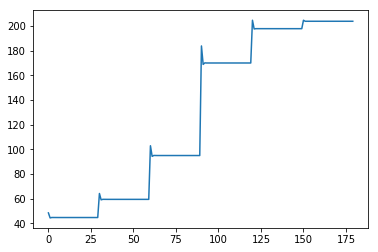

In [5]:
plt.plot(raw_dataset['Cutting force, N'])

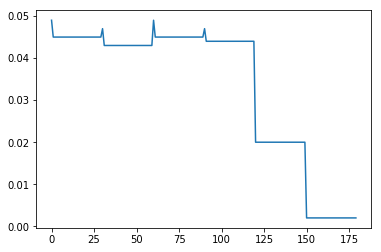

In [6]:
plt.plot(raw_dataset['Deformation of the workpiece, mm'])

In [7]:
plt.plot(raw_dataset['Feed S, mm, мм/зуб'])

KeyError: 'Подача S, мм/зуб'

E:\Games\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


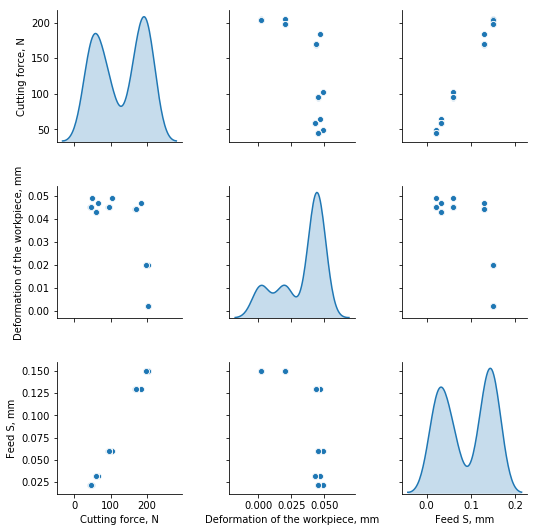

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[['Cutting force, N','Deformation of the workpiece, mm', 'Feed S, mm']], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop('Deformation of the workpiece, mm')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
"Cutting force, N",144.0,128.544931,65.604260,44.437,59.471,169.429,197.808,204.641
"Feed S, mm",144.0,0.090625,0.055002,0.022,0.032,0.130,0.150,0.150


In [10]:
train_labels = train_dataset.pop('Deformation of the workpiece, mm')
test_labels = test_dataset.pop('Deformation of the workpiece, mm')

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(8, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [13]:
model = build_model()

W1127 22:50:40.668115  8560 deprecation.py:506] From E:\Games\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [-0.3465617 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.10590141],
       [-0.26428863],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [16]:
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

W1127 22:51:25.350018  8560 deprecation.py:506] From E:\Games\Anaconda3\lib\site-packages\tensorflow_core\python\training\rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
495,0.000004,0.001273,0.000004,0.000013,0.001799,0.000013,495
496,0.000009,0.002255,0.000009,0.000014,0.002204,0.000014,496
497,0.000005,0.001477,0.000005,0.000015,0.002303,0.000015,497
498,0.000005,0.001423,0.000005,0.000013,0.001845,0.000013,498
499,0.000005,0.001400,0.000005,0.000021,0.003156,0.000021,499


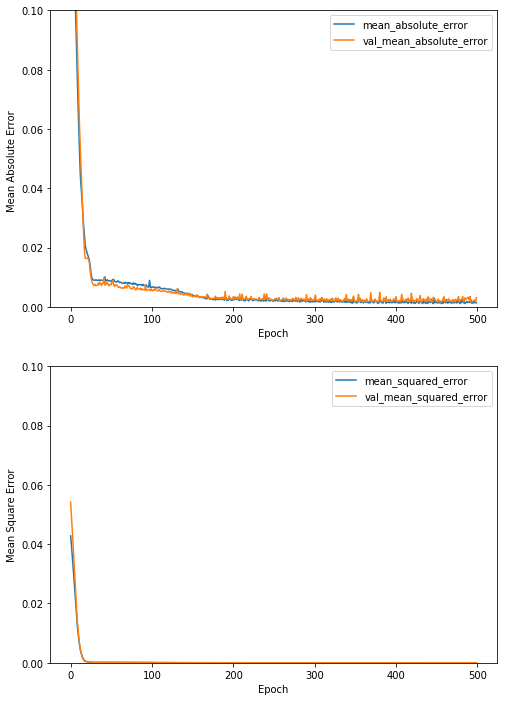

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(8,12))
  
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error ')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='mean_absolute_error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'val_mean_absolute_error')
  plt.ylim([0,0.1])
  plt.legend()
  
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='mean_squared_error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'val_mean_squared_error')
  plt.ylim([0,0.1])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
....................................................................................................
.............

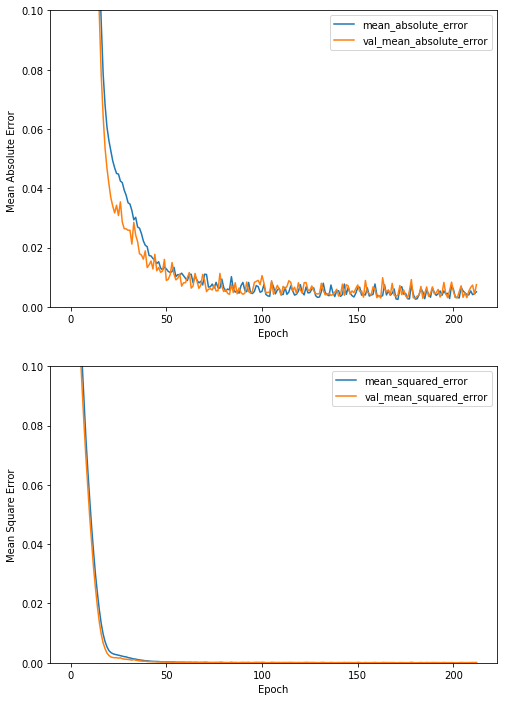

In [20]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Mean Absolute Error: {:5.4f} Deformation of the workpiece, mm".format(mae))

Mean Absolute Error: 0.0065 Deformation of the workpiece, mm


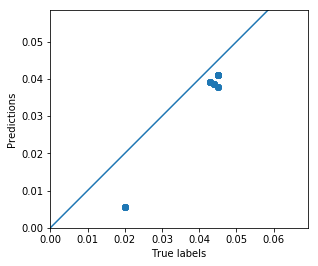

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True labels')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

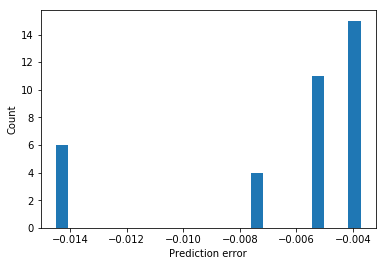

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction error")
_ = plt.ylabel("Count")

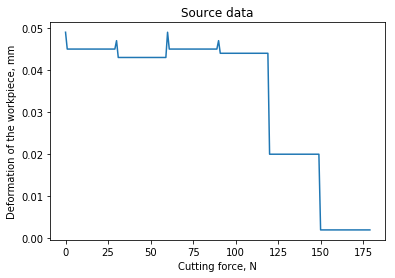

In [26]:
plt.title('Source data')
plt.ylabel('Deformation of the workpiece, mm')
plt.xlabel('Cutting force, N')
plt.plot(raw_dataset['Deformation of the workpiece, mm'])

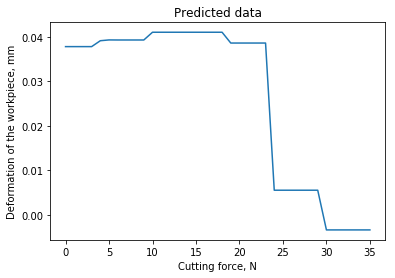

In [27]:
plt.title('Predicted data')
plt.ylabel('Deformation of the workpiece, mm')
plt.xlabel('Cutting force, N')
plt.plot(test_predictions)